# Louvain Community Detection on Citation Network

In this notebook, we will use cuGraph to identify communities in a citation network using the Louvain algorithm.

## Louvain Introduction

The Louvain method of community detection is a greedy hierarchical clustering algorithm which seeks to optimize Modularity as it progresses. Louvain starts with each vertex in its own clusters and iteratively merges groups using graph contraction.

See [Louvain community on Wikipedia](https://en.wikipedia.org/wiki/Louvain_method) for more details on the algorithm.

Modularity is calculated as follows:

$Q = \frac{1}{2m} \sum_{i,j} \left[ A_{ij} - \frac{k_i k_j}{2m} \right] \delta(c_i, c_j)$

Where:
- $A_{ij}$ - Does an edge exist between nodes i and j (1 if yes, 0 if no)
- $\frac{k_i k_j}{2m}$ - Expected number of edges in a random graph
- $\delta(c_i, c_j)$ - Are the two nodes in the same community? (0 for No, 1 for Yes)

### Key Features
- Optimizes modularity to find natural communities in networks
- Hierarchical approach that merges communities iteratively
- Efficient for large-scale graphs
- Returns partition assignments and modularity score

## Import Dependencies

In [1]:
%uv pip install networkx[default] gdown python-louvain leidenalg

Using Python 3.12.6 environment at: /usr/local
Resolved 32 packages in 227ms
Building python-louvain==0.16
Building python-louvain==0.16
⠙ Preparing packages... (0/6)
Building python-louvain==0.16
⠙ Preparing packages... (0/6)
Building python-louvain==0.16
⠙ Preparing packages... (0/6)
texttable  ------------------------------ 10.52 KiB/10.52 KiB
Building python-louvain==0.16
⠙ Preparing packages... (0/6)
texttable  ------------------------------ 10.52 KiB/10.52 KiB
Building python-louvain==0.16
⠙ Preparing packages... (0/6)
texttable  ------------------------------ 10.52 KiB/10.52 KiB
pysocks    ------------------------------     0 B/16.33 KiB
Building python-louvain==0.16
⠙ Preparing packages... (0/6)
texttable  ------------------------------ 10.52 KiB/10.52 KiB
pysocks    ------------------------------ 14.88 KiB/16.33 KiB
Building python-louvain==0.16
⠙ Preparing packages... (0/6)
texttable  ------------------------------ 10.52 KiB/10.52 KiB
pysocks    ------------------------------

In [2]:
!gdown https://drive.google.com/uc?id=1YHLtbt3_-A9crZox7KzRBM3BDtZgJn3T

Downloading...
From (original): https://drive.google.com/uc?id=1YHLtbt3_-A9crZox7KzRBM3BDtZgJn3T
From (redirected): https://drive.google.com/uc?id=1YHLtbt3_-A9crZox7KzRBM3BDtZgJn3T&confirm=t&uuid=3e86dd84-2b6b-4551-a6ba-418f5f9abf98
To: /root/openalex_works.db
100%|███████████████████████████████████████| 16.9G/16.9G [02:41<00:00, 105MB/s]


In [4]:
import pandas as pd
import sqlite3
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Install python-louvain if needed (uncomment if not installed)
# !pip install python-louvain

# ============================================
# CONFIGURATION: Set your target topic here
# ============================================
# TARGET_TOPIC_LIST = ["T10078", "T10001", "T10018", "T10030", "T10017"]# Change this to analyze a different topic

PAPERS_PER_TOPIC = 2000

In [7]:
TARGET_TOPICS = [
    "T10036",
    "T10320",
    "T10775",
    "T11273",
    "T11714",
    "T11307",
    "T11652",
    "T11512",
    "T10203",
    "T10538",
    "T12016",
    "T10028",
    "T12026",
    "T11396",
    "T11636",
    "T14414",
    "T10906",
    "T10100",
    "T10963",
    "T10848",
    "T10050",
    "T11975",
    "T12101",
    "T11612",
    "T10181",
    "T11710",
    "T11550",
    "T10664",
    "T12031",
    "T10201",
    "T10860",
    "T13083",
    "T13629",
    "T12380",
    "T12262",
    "T10531",
    "T11105",
    "T12923",
    "T14339",
    "T10627",
    "T10824",
    "T10601",
    "T10057",
    "T11448",
    "T11094",
    "T10331",
    "T10052",
    "T11659",
    "T10688",
    "T11019",
    "T11165",
    "T12549",
    "T10719",
    "T10812",
    "T10260",
    "T10430",
    "T12490",
    "T10743",
    "T11450",
    "T11675",
    "T12127",
    "T12423",
    "T10317",
    "T10101",
    "T14067",
    "T11181",
    "T11106",
    "T11719",
    "T11986",
    "T13650",
    "T13398",
    "T10799",
    "T11891",
    "T14280",
    "T11937",
    "T14201",
    "T11478",
    "T10715",
    "T10772",
    "T10054",
    "T10273",
    "T12222",
    "T10575",
    "T10125",
    "T11458",
    "T11409",
    "T10080",
    "T10711",
    "T10651",
    "T10714",
    "T10742",
    "T10796",
    "T11896",
    "T11932",
    "T12791",
    "T12024",
    "T10138",
    "T12216",
    "T12326",
    "T10237",
    "T10951",
    "T10400",
    "T10734",
    "T11045",
    "T10764",
    "T11504",
    "T11800",
    "T11644",
    "T11241",
    "T12122",
    "T11598",
    "T13999",
    "T10927",
    "T10270",
    "T13913",
    "T10462",
    "T10586",
    "T10653",
    "T10879",
    "T10191",
    "T10326",
    "T10709",
    "T10868",
    "T10888",
    "T10648",
    "T10789",
    "T11024",
    "T11938",
    "T13985",
    "T11572",
    "T11499",
    "T12885",
    "T10953",
    "T10350",
    "T10912",
    "T11446",
    "T14380",
    "T10712",
    "T13673",
    "T13166",
    "T12289",
    "T12863",
    "T10102",
    "T13976",
]


## Loading Citation-Paper Dataset

In [6]:
# Connect to the SQLite database file
conn = sqlite3.connect("/root/openalex_works.db")

# WHERE topic in ('T10078', 'T10001', 'T10018', 'T10030', 'T10017')
# MEMORY OPTIMIZATION: Load only the target topic list from database
print(f"Loading papers for topic: {TARGET_TOPIC_LIST}...")
topic_df = pd.read_sql_query(f"""
    SELECT *
    FROM works
    WHERE topic in ('T10078', 'T10001', 'T10018', 'T10030', 'T10017')
    """,
    conn
)
print(f"Loaded {len(topic_df)} papers for topic {TARGET_TOPIC_LIST}")
print(topic_df.head())

NameError: name 'TARGET_TOPIC_LIST' is not defined

In [6]:
# Count the number of papers per topic
topic_counts = topic_df['topic'].value_counts()
print(f"Total topics: {len(topic_counts)}")
print(f"Papers in target topic {TARGET_TOPIC_LIST}: {topic_counts.get(TARGET_TOPIC_LIST, 0)}")
print("\nTop 100 topics by paper count:")
print(topic_counts.head(100))

Total topics: 4513
Papers in target topic ['T10078', 'T10001', 'T10018', 'T10030', 'T10017']: topic
T10078    44179
T10001    38124
T10018    36624
T10030    34304
T10017    29681
Name: count, dtype: int64

Top 100 topics by paper count:
topic
T10078    44179
T10001    38124
T10018    36624
T10030    34304
T10017    29681
          ...  
T10167    13412
T10140    13410
T11791    13402
T10038    13401
T10878    13332
Name: count, Length: 100, dtype: int64


In [7]:
def get_openalex_topic_display_name(topic_id: str) -> str | None:
    """
    Retrieve the display name of an OpenAlex topic from its topic ID.
    
    Args:
        topic_id: The OpenAlex topic ID (format: T<number>)
        
    Returns:
        The display name of the topic, or None if an error occurred
    """
    try:
        url = f"https://api.openalex.org/topics/{topic_id}"
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()
        return data.get("display_name")
    except Exception:
        return None

# Get topic name for each paper
import requests

# Add topic display names to the dataframe
print("Fetching topic display names...")
unique_topics = topic_df['topic'].unique()
topic_names = {}

for topic_id in unique_topics:
    if pd.notna(topic_id):
        display_name = get_openalex_topic_display_name(topic_id)
        topic_names[topic_id] = display_name
        if display_name:
            print(f"{topic_id}: {display_name}")

# Add display names to dataframe
topic_df['topic_display_name'] = topic_df['topic'].map(topic_names)

Fetching topic display names...
T10346: Magnetic confinement fusion research
T10602: Glycosylation and Glycoproteins Research
T11048: Bacteriophages and microbial interactions
T10333: Meat and Animal Product Quality
T10036: Advanced Neural Network Applications
T10002: Advanced Chemical Physics Studies
T11970: Molecular Biology Techniques and Applications
T12196: Community Health and Development
T13937: Genetics, Bioinformatics, and Biomedical Research
T10320: Neural Networks and Applications
T10037: Physics of Superconductivity and Magnetism
T13091: Human Health and Disease
T10556: Global Cancer Incidence and Screening
T11235: Statistical Methods in Clinical Trials
T10467: Psychometric Methodologies and Testing
T10015: Genomics and Phylogenetic Studies
T11482: RNA modifications and cancer
T11162: Enzyme Structure and Function
T11071: Treatment of Major Depression
T12175: Social Representations and Identity
T12859: Cell Image Analysis Techniques
T10206: Meta-analysis and systematic revi

In [ ]:
print(topic_df['topic_display_name'])

In [8]:
# Connect to the SQLite database file
conn = sqlite3.connect("/root/openalex_works.db")

# MEMORY OPTIMIZATION: Load only 2000 papers per topic using a single SQL query
print(f"Loading {PAPERS_PER_TOPIC} papers for each of {len(TARGET_TOPICS)} topics...")

# Create placeholders for the IN clause
placeholders = ', '.join(['?' for _ in TARGET_TOPICS])

# Use a window function to limit papers per topic in a single query
topic_df = pd.read_sql_query(f"""
    SELECT *
    FROM (
        SELECT *,
               ROW_NUMBER() OVER (PARTITION BY topic ORDER BY cited_by_count DESC) as row_num
        FROM works
        WHERE topic IN ({placeholders})
    )
    WHERE row_num <= ?
    """,
    conn,
    params=(*TARGET_TOPICS, PAPERS_PER_TOPIC)
)

# Drop the helper column
topic_df = topic_df.drop('row_num', axis=1)

print(f"\n{'='*60}")
print(f"TOTAL DATA LOADED")
print(f"{'='*60}")
print(f"Total papers across all topics: {len(topic_df)}")
print(f"Topics included: {', '.join(TARGET_TOPICS)}")
print(f"Papers per topic breakdown:")
for topic in TARGET_TOPICS:
    count = len(topic_df[topic_df['topic'] == topic])
    print(f"  {topic}: {count} papers")
print(f"\nSample data:")
print(topic_df.head())

Loading 2000 papers for each of 144 topics...

TOTAL DATA LOADED
Total papers across all topics: 230554
Topics included: T10036, T10320, T10775, T11273, T11714, T11307, T11652, T11512, T10203, T10538, T12016, T10028, T12026, T11396, T11636, T14414, T10906, T10100, T10963, T10848, T10050, T11975, T12101, T11612, T10181, T11710, T11550, T10664, T12031, T10201, T10860, T13083, T13629, T12380, T12262, T10531, T11105, T12923, T14339, T10627, T10824, T10601, T10057, T11448, T11094, T10331, T10052, T11659, T10688, T11019, T11165, T12549, T10719, T10812, T10260, T10430, T12490, T10743, T11450, T11675, T12127, T12423, T10317, T10101, T14067, T11181, T11106, T11719, T11986, T13650, T13398, T10799, T11891, T14280, T11937, T14201, T11478, T10715, T10772, T10054, T10273, T12222, T10575, T10125, T11458, T11409, T10080, T10711, T10651, T10714, T10742, T10796, T11896, T11932, T12791, T12024, T10138, T12216, T12326, T10237, T10951, T10400, T10734, T11045, T10764, T11504, T11800, T11644, T11241, T12122,

## Build Citation Network

In [9]:
import ast

# Parse referenced_works into Python lists
def parse_list_cell(x):
    if x is None:
        return []
    if isinstance(x, (list, tuple)):
        return list(x)
    try:
        return ast.literal_eval(x)
    except Exception:
        s = str(x).strip()
        if s.startswith("[") and s.endswith("]"):
            s = s[1:-1].strip()
        if not s:
            return []
        return [e.strip().strip('"').strip("'") for e in s.split(",") if e.strip()]

topic_df['referenced_works_parsed'] = topic_df['referenced_works'].apply(parse_list_cell)

# Create an edge list DataFrame (source -> referenced_work)
valid_ids = set(topic_df['id'].values)
edges = [
    (src, dst)
    for src, refs in zip(topic_df['id'], topic_df['referenced_works_parsed'])
    for dst in refs
    if dst and dst in valid_ids  # Combined check: non-empty AND in valid set
]

edges_df = pd.DataFrame(edges, columns=['source', 'target'])
print(f"Built {len(edges_df)} edges from {len(topic_df)} papers")
print(f"Average references per paper: {len(edges_df) / len(topic_df):.2f}")
edges_df.head()

Built 3149647 edges from 230554 papers
Average references per paper: 13.66


,source,target
0,W2250539671,W2251012068
1,W2250539671,W2118020653
2,W2250539671,W2141599568
3,W2250539671,W2117130368
4,W2250539671,W2164019165


In [10]:
print(f"\n{'='*60}")
print(f"INTER-TOPIC CITATION ANALYSIS")
print(f"{'='*60}")

# Create a mapping from paper ID to topic
paper_to_topic = dict(zip(topic_df['id'], topic_df['topic']))

# Initialize the inter-topic citation matrix
topic_list = sorted(TARGET_TOPICS)
n_topics = len(topic_list)
inter_topic_matrix = pd.DataFrame(
    0, 
    index=topic_list, 
    columns=topic_list,
    dtype=int
)

# Count edges between topics
print(f"\nCounting citations between topics...")
for _, row in edges_df.iterrows():
    source_topic = paper_to_topic.get(row['source'])
    target_topic = paper_to_topic.get(row['target'])
    
    if source_topic and target_topic:
        # source_topic cites target_topic
        inter_topic_matrix.loc[source_topic, target_topic] += 1

print(f"✓ Inter-topic citation matrix computed")
print(f"\nInter-Topic Citation Matrix:")
print(f"(Rows cite Columns)")
print(inter_topic_matrix)

# Calculate total inter-topic vs intra-topic citations
intra_topic_citations = sum([inter_topic_matrix.loc[t, t] for t in topic_list])
total_citations = inter_topic_matrix.sum().sum()
inter_topic_citations = total_citations - intra_topic_citations

print(f"\n{'─'*60}")
print(f"Citation Statistics:")
print(f"  Total citations: {total_citations:,}")
print(f"  Intra-topic citations (within same topic): {intra_topic_citations:,} ({100*intra_topic_citations/total_citations:.1f}%)")
print(f"  Inter-topic citations (between topics): {inter_topic_citations:,} ({100*inter_topic_citations/total_citations:.1f}%)")

# Save matrix to CSV
matrix_file = f"inter_topic_citations.csv"
inter_topic_matrix.to_csv(matrix_file)
print(f"\n✓ Matrix saved to: {matrix_file}")


INTER-TOPIC CITATION ANALYSIS

Counting citations between topics...
✓ Inter-topic citation matrix computed

Inter-Topic Citation Matrix:
(Rows cite Columns)
        T10028  T10036  T10050  T10052  T10054  T10057  T10080  T10100  \
T10028   13355     372      19       9      26     127       1      22   
T10036     275   26009       2    1023     344     337       4      71   
T10050       6       0   21031      19       1      20       1      47   
T10052      21     899      80   16013      49     293       0     300   
T10054       1     168       0       9   12039      18      16      16   
...        ...     ...     ...     ...     ...     ...     ...     ...   
T14201       2       0       0       0       1       0       0       0   
T14280       3       1       0       0       2      13       3       0   
T14339      18     155       5     164       5      66       1       7   
T14380       0       0       0       0       0       0       0       0   
T14414       1       0      

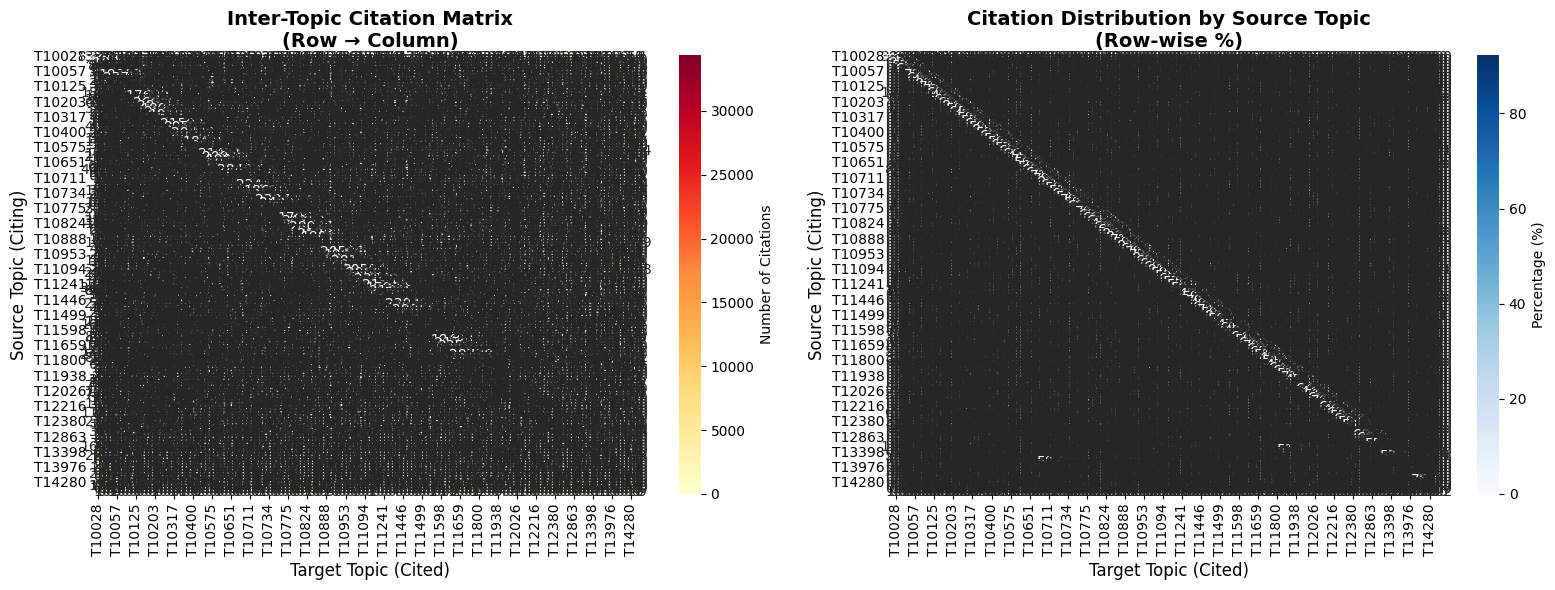


ROW-WISE CITATION DISTRIBUTION (%)
(What % of each topic's citations go to each target topic)
        T10028  T10036  T10050  T10052  T10054  T10057  T10080  T10100  \
T10028    38.3     1.1     0.1     0.0     0.1     0.4     0.0     0.1   
T10036     0.5    51.2     0.0     2.0     0.7     0.7     0.0     0.1   
T10050     0.0     0.0    92.2     0.1     0.0     0.1     0.0     0.2   
T10052     0.1     3.2     0.3    57.5     0.2     1.1     0.0     1.1   
T10054     0.0     1.0     0.0     0.1    68.5     0.1     0.1     0.1   
...        ...     ...     ...     ...     ...     ...     ...     ...   
T14201     0.2     0.0     0.0     0.0     0.1     0.0     0.0     0.0   
T14280     0.4     0.1     0.0     0.0     0.2     1.5     0.4     0.0   
T14339     0.5     4.0     0.1     4.2     0.1     1.7     0.0     0.2   
T14380     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
T14414     1.6     0.0     0.0     0.0     1.6     0.0     0.0     0.0   

        T10101  

In [15]:
# Visualize the inter-topic citation matrix
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Raw citation counts (heatmap)
sns.heatmap(
    inter_topic_matrix, 
    annot=True, 
    fmt='d', 
    cmap='YlOrRd',
    ax=axes[0],
    cbar_kws={'label': 'Number of Citations'},
    linewidths=0.5,
    linecolor='gray'
)
axes[0].set_title('Inter-Topic Citation Matrix\n(Row → Column)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Target Topic (Cited)', fontsize=12)
axes[0].set_ylabel('Source Topic (Citing)', fontsize=12)

# Plot 2: Normalized by row (what % of each topic's citations go to each target)
row_normalized = inter_topic_matrix.div(inter_topic_matrix.sum(axis=1), axis=0) * 100
sns.heatmap(
    row_normalized, 
    annot=True, 
    fmt='.1f', 
    cmap='Blues',
    ax=axes[1],
    cbar_kws={'label': 'Percentage (%)'},
    linewidths=0.5,
    linecolor='gray'
)
axes[1].set_title('Citation Distribution by Source Topic\n(Row-wise %)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Target Topic (Cited)', fontsize=12)
axes[1].set_ylabel('Source Topic (Citing)', fontsize=12)

plt.tight_layout()
plt.show()

print(f"\n{'='*60}")
print(f"ROW-WISE CITATION DISTRIBUTION (%)")
print(f"{'='*60}")
print("(What % of each topic's citations go to each target topic)")
print(row_normalized.round(1))

In [11]:
print(f"\n{'='*60}")
print(f"NETWORKX GRAPH CONSTRUCTION")
print(f"{'='*60}")

if len(edges_df) > 0:
    # Create NetworkX DIRECTED graph from edge list (citation networks are directed)
    G_directed = nx.from_pandas_edgelist(
        edges_df,
        source='source',
        target='target',
        create_using=nx.DiGraph()
    )

    print(f"✓ Directed graph created:")
    print(f"  - Nodes: {G_directed.number_of_nodes():,}")
    print(f"  - Edges: {G_directed.number_of_edges():,}")
    print(f"  - Density: {nx.density(G_directed):.6f}")

    # For Louvain algorithm, we need an undirected graph
    # Convert directed to undirected (treats citations as symmetric relationships)
    # G_undirected = G_directed.to_undirected()

    # print(f"\n✓ Converted to undirected graph for Louvain:")
    # print(f"  - Nodes: {G_undirected.number_of_nodes():,}")
    # print(f"  - Edges: {G_undirected.number_of_edges():,}")
    # print(f"  - Note: Directed edges collapsed to undirected")
else:
    print("⚠️ No edges to process")


NETWORKX GRAPH CONSTRUCTION
✓ Directed graph created:
  - Nodes: 222,407
  - Edges: 3,149,647
  - Density: 0.000064


In [18]:
nx.community.louvain_communities(G_directed, seed=42)

[{'W2091311622',
  'W2084303987',
  'W2114308984',
  'W2285716846',
  'W2056351208',
  'W2165462968',
  'W1976963145',
  'W2052472624',
  'W2034672517',
  'W2092145507',
  'W1986798073',
  'W2054701321',
  'W2396506019',
  'W2075128774',
  'W2909556548',
  'W2067143430',
  'W1985026590',
  'W2036612842',
  'W2131837628',
  'W2143963907',
  'W2484233482',
  'W2110957968',
  'W1972200033',
  'W2082822768',
  'W2002198448',
  'W2109763519',
  'W2163538100',
  'W2134335829',
  'W2167741229',
  'W2518703433',
  'W2168750284',
  'W2077975884',
  'W1983072117',
  'W2183531564',
  'W2051254917',
  'W2092042037',
  'W1634238595',
  'W2041029608',
  'W3022390469',
  'W3200480161',
  'W2033156821',
  'W2011958855',
  'W2030077230',
  'W2062637542',
  'W2781363518',
  'W2006644083',
  'W2106781946',
  'W2007113204',
  'W2317134492',
  'W2342007132',
  'W2152956184',
  'W2010197317',
  'W2305153561',
  'W2094294558',
  'W2053160122',
  'W2097313141',
  'W1861675434',
  'W2010741801',
  'W2050474528

In [21]:
import community as community_louvain
import pandas as pd
import matplotlib.pyplot as plt

# Get hierarchical partitions (one per level)
dendo = community_louvain.generate_dendrogram(
    G_directed, random_state=42, weight=None, resolution=1.0
)

level_stats = []
agg = G_directed.copy()
for level in range(len(dendo)):
    part = community_louvain.partition_at_level(dendo, level)  # node -> community
    mod = community_louvain.modularity(part, G_directed, weight=None, resolution=1.0)
    level_stats.append({
        "level": level,
        "n_nodes": agg.number_of_nodes(),
        "n_edges": agg.number_of_edges(),
        "n_comms": len(set(part.values())),
        "modularity": mod,
    })
    # collapse graph for next level to track arc counts at the coarser scale
    agg = community_louvain.induced_graph(part, agg, weight=None)

stats_df = pd.DataFrame(level_stats)
print(stats_df)

fig, ax = plt.subplots()
ax.plot(stats_df["level"], stats_df["modularity"], marker="o")
ax.set_xlabel("Louvain level")
ax.set_ylabel("Modularity")
ax.set_title("Modularity across levels")
plt.show()


TypeError: Bad graph type, use only non directed graph

In [ ]:
print(f"\n{'='*60}")
print(f"LOUVAIN COMMUNITY DETECTION")
print(f"{'='*60}")

# Run Louvain algorithm (returns dict: node -> community_id)
partition = community_louvain.best_partition(G_directed)

# Calculate modularity score
modularity_score = community_louvain.modularity(partition, G_directed)

# Convert partition dict to DataFrame
louvain_result = pd.DataFrame([
    {'vertex_id': node, 'partition': comm}
    for node, comm in partition.items()
])

print(f"\n✓ Louvain completed:")
print(f"  - Modularity score: {modularity_score:.6f}")
print(f"  - Number of communities: {louvain_result['partition'].nunique()}")

# Display top communities by size

community_sizes = louvain_result['partition'].value_counts().reset_index()
print(community_sizes.head(10))

community_sizes.columns = ['partition', 'size']
print(f"\nTop 10 communities by size:")

community_sizes = community_sizes.sort_values('size', ascending=False)


LOUVAIN COMMUNITY DETECTION


AttributeError: module 'community' has no attribute 'best_partition'

In [ ]:
## Community Statistics and Analysis

In [ ]:
# Visualize community size distribution
plt.figure(figsize=(14, 5))

# Plot 1: Community size distribution (bar chart)
plt.subplot(1, 2, 1)
community_sizes_pd = community_sizes.head(20).to_pandas()
plt.bar(range(len(community_sizes_pd)), community_sizes_pd['size'])
plt.xlabel('Community Rank', fontsize=12)
plt.ylabel('Number of Papers', fontsize=12)
plt.title(f'Top 20 Community Sizes (Topic: {TARGET_TOPIC})', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

# Plot 2: Community size distribution (histogram)
plt.subplot(1, 2, 2)
all_sizes = community_sizes.to_pandas()['size']
plt.hist(all_sizes, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Community Size', fontsize=12)
plt.ylabel('Number of Communities', fontsize=12)
plt.title('Community Size Distribution', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\n{'='*60}")
print(f"COMMUNITY STATISTICS")
print(f"{'='*60}")
print(f"Total communities: {len(community_sizes)}")
print(f"Largest community size: {all_sizes.max()}")
print(f"Smallest community size: {all_sizes.min()}")
print(f"Average community size: {all_sizes.mean():.2f}")
print(f"Median community size: {all_sizes.median():.2f}")

In [ ]:
## Analyze Top Communities

In [ ]:
# Analyze top 5 communities by size
louvain_pandas = louvain_result.to_pandas()
top_communities = community_sizes.head(5)['partition'].to_pandas().tolist()

print(f"{'='*60}")
print(f"TOP 5 LARGEST COMMUNITIES - PAPER ANALYSIS")
print(f"{'='*60}\n")

for rank, comm_id in enumerate(top_communities, 1):
    # Get papers in this community
    comm_papers = louvain_pandas[louvain_pandas['partition'] == comm_id]['vertex_id'].tolist()

    # Get paper metadata
    comm_df = topic_df[topic_df['id'].isin(comm_papers)]

    print(f"Community {rank} (ID: {comm_id})")
    print(f"{'─'*60}")
    print(f"Size: {len(comm_papers)} papers")
    print(f"Total citations: {comm_df['cited_by_count'].sum():,}")
    print(f"Average citations per paper: {comm_df['cited_by_count'].mean():.2f}")

    # Show top cited papers in this community
    top_cited = comm_df.nlargest(3, 'cited_by_count')
    print(f"\nTop 3 most cited papers in this community:")
    for idx, (_, paper) in enumerate(top_cited.iterrows(), 1):
        print(f"  {idx}. {paper['title'][:60]}...")
        print(f"     Citations: {paper['cited_by_count']}, Year: {paper['publication_date']}")
    print()

In [ ]:
## Community Characteristics: Citations and Years

In [ ]:
# Analyze citation patterns and publication years by community
community_stats = []

for comm_id in top_communities:
    comm_papers = louvain_pandas[louvain_pandas['partition'] == comm_id]['vertex_id'].tolist()
    comm_df = topic_df[topic_df['id'].isin(comm_papers)]

    # Extract year from publication_date
    comm_df['year'] = pd.to_datetime(comm_df['publication_date']).dt.year

    community_stats.append({
        'community': comm_id,
        'size': len(comm_papers),
        'avg_citations': comm_df['cited_by_count'].mean(),
        'median_citations': comm_df['cited_by_count'].median(),
        'total_citations': comm_df['cited_by_count'].sum(),
        'avg_year': comm_df['year'].mean(),
        'year_range': f"{comm_df['year'].min()}-{comm_df['year'].max()}"
    })

stats_df = pd.DataFrame(community_stats)

print(f"\n{'='*60}")
print(f"COMMUNITY CHARACTERISTICS SUMMARY")
print(f"{'='*60}\n")
print(stats_df.to_string(index=False))

In [ ]:
# Visualize community characteristics
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Average citations by community
axes[0].bar(range(len(stats_df)), stats_df['avg_citations'], color='steelblue')
axes[0].set_xlabel('Community Rank', fontsize=12)
axes[0].set_ylabel('Average Citations', fontsize=12)
axes[0].set_title('Average Citations per Community', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_xticks(range(len(stats_df)))
axes[0].set_xticklabels([f"C{i+1}" for i in range(len(stats_df))])

# Plot 2: Average publication year by community
axes[1].bar(range(len(stats_df)), stats_df['avg_year'], color='coral')
axes[1].set_xlabel('Community Rank', fontsize=12)
axes[1].set_ylabel('Average Publication Year', fontsize=12)
axes[1].set_title('Average Publication Year per Community', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].set_xticks(range(len(stats_df)))
axes[1].set_xticklabels([f"C{i+1}" for i in range(len(stats_df))])

plt.tight_layout()
plt.show()

## Export Community Assignments

You can export the community assignments for further analysis:

In [ ]:
# Merge community assignments with paper metadata
output_df = louvain_pandas[['vertex_id', 'partition']].merge(
    topic_df[['id', 'title', 'publication_date', 'cited_by_count']],
    left_on='vertex_id',
    right_on='id',
    how='left'
)

# Save to CSV
output_file = f'louvain_communities_{TARGET_TOPIC}.csv'
output_df.to_csv(output_file, index=False)

print(f"✓ Community assignments saved to: {output_file}")
print(f"\nSummary:")
print(f"  - Total papers: {len(output_df)}")
print(f"  - Total communities: {output_df['partition'].nunique()}")
print(f"  - Modularity score: {modularity_score:.6f}")

output_df.head(10)

## Leiden

In [12]:
# Convert to igraph
import pandas as pd
import networkx as nx
import igraph as ig
import leidenalg as la
import matplotlib.pyplot as plt

def nx_to_igraph(G_nx, weight_attr=None):
    if weight_attr:
        edgelist = [
            (u, v, d.get(weight_attr, 1.0))
            for u, v, d in G_nx.edges(data=True)
        ]
        g = ig.Graph.TupleList(edgelist, directed=G_nx.is_directed(), weights=True)
        g.es["weight"] = [w for *_, w in edgelist]
    else:
        g = ig.Graph.TupleList(G_nx.edges(), directed=G_nx.is_directed())
    g.vs["name"] = list(G_nx.nodes())
    return g

g0 = nx_to_igraph(G_directed, weight_attr=None)  # set weight_attr if you have edge weights
print(g0.summary())


IGRAPH DN-- 222407 3149647 -- 
+ attr: name (v)


In [41]:
def run_leiden_verbose(g, resolution=1.0, seed=42, max_iterations=10):
    """
    Run Leiden algorithm and track statistics at each iteration.
    
    Note: Leiden doesn't naturally work in hierarchical levels like shown in the original code.
    Instead, it refines partitions iteratively. This function runs Leiden once and tracks
    the refinement process.
    """
    stats = []
    
    # Run Leiden algorithm with CPM (Constant Potts Model) for resolution parameter
    print(f"\nRunning Leiden algorithm...")
    print(f"  Resolution: {resolution}")
    print(f"  Random seed: {seed}")
    
    partition = la.find_partition(
        g,
        la.RBConfigurationVertexPartition,  # Resolution-aware partition
        resolution_parameter=resolution,
        seed=seed,
        n_iterations=max_iterations
    )
    
    membership = partition.membership
    n_comms = len(set(membership))
    
    stats.append({
        "n_nodes": g.vcount(),
        "n_edges": g.ecount(),
        "n_communities": n_comms,
        "modularity": partition.modularity,
        "quality": partition.quality()
    })
    
    return partition, pd.DataFrame(stats), membership
    
    # Run Leiden algorithm
print(f"\n{'='*60}")
print(f"LEIDEN COMMUNITY DETECTION")
print(f"{'='*60}")

MAX_ITERATIONS = 50

for iteration in range(1, MAX_ITERATIONS+1):
    leiden_partition, leiden_stats, leiden_membership = run_leiden_verbose(
        g0, 
        resolution=1.0, 
        seed=42,
        max_iterations=iteration
    )
    
    print(leiden_stats.to_string(index=False))


LEIDEN COMMUNITY DETECTION

Running Leiden algorithm...
  Resolution: 1.0
  Random seed: 42
 n_nodes  n_edges  n_communities  modularity      quality
  222407  3149647            258    0.772087 2.431803e+06

Running Leiden algorithm...
  Resolution: 1.0
  Random seed: 42
 n_nodes  n_edges  n_communities  modularity      quality
  222407  3149647            259    0.779034 2.453683e+06

Running Leiden algorithm...
  Resolution: 1.0
  Random seed: 42
 n_nodes  n_edges  n_communities  modularity      quality
  222407  3149647            259    0.779948 2.456560e+06

Running Leiden algorithm...
  Resolution: 1.0
  Random seed: 42
 n_nodes  n_edges  n_communities  modularity      quality
  222407  3149647            259    0.780819 2.459305e+06

Running Leiden algorithm...
  Resolution: 1.0
  Random seed: 42
 n_nodes  n_edges  n_communities  modularity      quality
  222407  3149647            259    0.781218 2.460562e+06

Running Leiden algorithm...
  Resolution: 1.0
  Random seed: 42
 n

Leiden without verbosity

In [ ]:
import pandas as pd
import igraph as ig
import leidenalg as la

def run_leiden_simple(g, resolution=1.0, weight_attr=None, seed=42,
                      partition_cls=la.RBConfigurationVertexPartition):
    weights = g.es[weight_attr] if weight_attr and weight_attr in g.es.attributes() else None
    part = la.find_partition(
        g,
        partition_cls,
        weights=weights,
        resolution_parameter=resolution,
        seed=seed,
        n_iterations=-1,
    )
    return part  # .membership, .quality(), etc.

# Use your igraph graph (e.g., g0 from earlier)
leiden_part = run_leiden_simple(g0, resolution=1, weight_attr=None, seed=42)

print(f"Communities: {len(set(leiden_part.membership))}")
print(f"Modularity:  {leiden_part.modularity:.4f}")

# Map back to node IDs and get sizes
leiden_result = pd.DataFrame({
    "paper_id": g0.vs["name"],
    "cluster_id": leiden_part.membership
})
comm_sizes = leiden_result["cluster_id"].value_counts().sort_values(ascending=False)
print(comm_sizes.head(10))

leiden_result.to_csv(f"leiden_communities.csv", index=False)

In [52]:
leiden_part2 = la.find_partition(g0, la.RBConfigurationVertexPartition, weights=None, resolution_parameter=1.0, seed=42, initial_membership=leiden_part.membership)

print(f"Communities: {len(set(leiden_part2.membership))}")
print(f"Modularity:  {leiden_part2.modularity:.4f}")

leiden_result = pd.DataFrame({
    "paper_id": g0.vs["name"],
    "cluster_id": leiden_part2.membership
})
comm_sizes = leiden_result["cluster_id"].value_counts().sort_values(ascending=False)
print(comm_sizes.head(10))

leiden_result.to_csv(f"leiden_communities.csv", index=False)

Communities: 259
Modularity:  0.7803
cluster_id
0    16313
1    16215
2    15860
3    14699
4    14199
5    14120
6    14026
7    12073
8     9873
9     9727
Name: count, dtype: int64


In [41]:
print(len(leiden_result))

222407


In [17]:
print(comm_sizes.tail(50))

cluster_id
179    2
178    2
177    2
166    2
165    2
164    2
251    1
223    1
215    1
229    1
228    1
227    1
226    1
225    1
233    1
230    1
234    1
237    1
236    1
235    1
231    1
232    1
240    1
217    1
239    1
219    1
218    1
241    1
238    1
220    1
221    1
222    1
242    1
243    1
244    1
246    1
245    1
248    1
216    1
224    1
258    1
253    1
257    1
256    1
254    1
255    1
252    1
247    1
249    1
250    1
Name: count, dtype: int64


In [18]:
# Create a mapping from topic to community label
topic_to_community = {topic: idx for idx, topic in enumerate(TARGET_TOPICS)}
print("Topic to community mapping:")
for topic, community in topic_to_community.items():
    print(f"{topic} -> Community {community}")

# Create ground truth dataframe
ground_truth_df = topic_df[['id', 'topic']].copy()
ground_truth_df['community'] = ground_truth_df['topic'].map(topic_to_community)
ground_truth_df = ground_truth_df[['id', 'community']]

# Rename the columns: id to paper_id and community to cluster_id.
ground_truth_df = ground_truth_df.rename(columns={'id': 'paper_id', 'community': 'cluster_id'})

print(f"\nGround truth communities created:")
print(f"Total papers: {len(ground_truth_df)}")
print(ground_truth_df.head(10))

ground_truth_df.to_csv("ground_truth_communities.csv", index=False)



Topic to community mapping:
T10036 -> Community 0
T10320 -> Community 1
T10775 -> Community 2
T11273 -> Community 3
T11714 -> Community 4
T11307 -> Community 5
T11652 -> Community 6
T11512 -> Community 7
T10203 -> Community 8
T10538 -> Community 9
T12016 -> Community 10
T10028 -> Community 11
T12026 -> Community 12
T11396 -> Community 13
T11636 -> Community 14
T14414 -> Community 15
T10906 -> Community 16
T10100 -> Community 17
T10963 -> Community 18
T10848 -> Community 19
T10050 -> Community 20
T11975 -> Community 21
T12101 -> Community 22
T11612 -> Community 23
T10181 -> Community 24
T11710 -> Community 25
T11550 -> Community 26
T10664 -> Community 27
T12031 -> Community 28
T10201 -> Community 29
T10860 -> Community 30
T13083 -> Community 31
T13629 -> Community 32
T12380 -> Community 33
T12262 -> Community 34
T10531 -> Community 35
T11105 -> Community 36
T12923 -> Community 37
T14339 -> Community 38
T10627 -> Community 39
T10824 -> Community 40
T10601 -> Community 41
T10057 -> Commun

# Evaluation

In [49]:
"""
Community Detection Evaluation Metrics

This module provides functions to load community detection results and calculate
evaluation metrics comparing predicted clusters to ground truth.

Usage Examples:
    # External indices (with ground truth)
    >>> results = calculate_external_indices('preds.csv', 'truth.csv')
    
    # Internal indices - basic stats only (no graph loading)
    >>> results = calculate_internal_indices('communities.csv', n_edges=5_438_287)
    
    # Internal indices - full metrics with graph loading
    >>> results = calculate_internal_indices('communities.csv', 'edges.csv')
    
    # Internal indices - sampled graph for large datasets
    >>> results = calculate_internal_indices('communities.csv', 'edges.csv', max_edges=1_000_000)
"""

import pandas as pd
import numpy as np
import networkx as nx
from pathlib import Path
from typing import Union, Tuple, Dict, Optional
from sklearn.metrics import (
    adjusted_mutual_info_score, 
    adjusted_rand_score,
    normalized_mutual_info_score,
    homogeneity_completeness_v_measure,
    fowlkes_mallows_score
)
from sklearn.metrics.cluster import contingency_matrix


def load_community_labels(filepath: Union[str, Path]) -> pd.DataFrame:
    """
    Load community detection results or ground truth from CSV file.
    
    Args:
        filepath: Path to CSV file containing community assignments
                 Expected columns: 'paper_id', 'cluster_id'
    
    Returns:
        DataFrame with columns: 'paper_id', 'cluster_id'
        Sorted by paper_id for consistent ordering
    
    Raises:
        FileNotFoundError: If the CSV file doesn't exist
        ValueError: If required columns are missing
    """
    filepath = Path(filepath)
    
    if not filepath.exists():
        raise FileNotFoundError(f"Community CSV file not found: {filepath}")
    
    # Load CSV
    df = pd.read_csv(filepath, dtype={'paper_id': str, 'cluster_id': str})
    
    # Validate required columns
    if 'paper_id' not in df.columns:
        raise ValueError(f"CSV must contain 'paper_id' column. Found: {list(df.columns)}")
    if 'cluster_id' not in df.columns:
        raise ValueError(f"CSV must contain 'cluster_id' column. Found: {list(df.columns)}")
    
    # Keep only required columns and sort by paper_id for consistency
    df = df[['paper_id', 'cluster_id']].sort_values('paper_id').reset_index(drop=True)
    
    # Ensure cluster_id is string for consistency
    df['cluster_id'] = df['cluster_id'].astype(str)
    
    return df


def align_labels(preds_df: pd.DataFrame, ground_truth_df: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray]:
    """
    Align prediction and ground truth labels by paper_id.
    
    Only papers that appear in both dataframes are included in the output.
    
    Args:
        preds_df: DataFrame with predicted clusters (columns: paper_id, cluster_id)
        ground_truth_df: DataFrame with ground truth clusters (columns: paper_id, cluster_id)
    
    Returns:
        Tuple of (preds, ground_truths) as numpy arrays of cluster labels
        Both arrays have the same length and correspond to the same papers
    """
    # Merge on paper_id to find common papers
    merged = preds_df.merge(
        ground_truth_df,
        on='paper_id',
        suffixes=('_pred', '_true')
    )
    
    if len(merged) == 0:
        raise ValueError("No common papers found between predictions and ground truth")
    
    # Extract aligned labels
    preds = merged['cluster_id_pred'].values
    ground_truths = merged['cluster_id_true'].values
    
    return preds, ground_truths


def calculate_ami(preds: np.ndarray, ground_truths: np.ndarray) -> float:
    """
    Calculate Adjusted Mutual Information (AMI).
    
    AMI measures the agreement between two clusterings, adjusted for chance.
    - Range: [-1, 1] (typically [0, 1])
    - 1.0 = perfect agreement
    - 0.0 = random clustering
    - Negative values indicate worse than random
    
    Args:
        preds: Predicted cluster labels (1D array)
        ground_truths: Ground truth cluster labels (1D array)
    
    Returns:
        AMI score (float)
    
    Raises:
        ValueError: If input arrays have different lengths
    """
    if len(preds) != len(ground_truths):
        raise ValueError(
            f"Input arrays must have same length. "
            f"Got preds: {len(preds)}, ground_truths: {len(ground_truths)}"
        )
    
    return adjusted_mutual_info_score(ground_truths, preds)


def calculate_ari(preds: np.ndarray, ground_truths: np.ndarray) -> float:
    """
    Calculate Adjusted Rand Index (ARI).
    
    ARI measures the similarity between two clusterings, adjusted for chance.
    - Range: [-1, 1]
    - 1.0 = perfect agreement (identical clustering)
    - 0.0 = random clustering
    - Negative values indicate worse than random
    
    Args:
        preds: Predicted cluster labels (1D array)
        ground_truths: Ground truth cluster labels (1D array)
    
    Returns:
        ARI score (float)
    
    Raises:
        ValueError: If input arrays have different lengths
    """
    if len(preds) != len(ground_truths):
        raise ValueError(
            f"Input arrays must have same length. "
            f"Got preds: {len(preds)}, ground_truths: {len(ground_truths)}"
        )
    
    return adjusted_rand_score(ground_truths, preds)


def calculate_vi(preds: np.ndarray, ground_truths: np.ndarray) -> float:
    """
    Calculate Variation of Information (VI).
    
    VI measures the distance between two clusterings based on entropy.
    - Range: [0, log(N)] where N is the number of samples
    - 0.0 = perfect agreement (identical clustering)
    - Higher values = more different clusterings
    - Unlike AMI/ARI, lower is better
    
    Args:
        preds: Predicted cluster labels (1D array)
        ground_truths: Ground truth cluster labels (1D array)
    
    Returns:
        VI score (float)
    
    Raises:
        ValueError: If input arrays have different lengths
    """
    if len(preds) != len(ground_truths):
        raise ValueError(
            f"Input arrays must have same length. "
            f"Got preds: {len(preds)}, ground_truths: {len(ground_truths)}"
        )
    
    # Get contingency matrix
    contingency = contingency_matrix(ground_truths, preds)
    
    # Calculate probabilities
    n = np.sum(contingency)
    contingency = contingency.astype(float)
    
    # Joint probability
    pij = contingency / n
    
    # Marginal probabilities
    pi = np.sum(pij, axis=1)  # P(true cluster)
    pj = np.sum(pij, axis=0)  # P(pred cluster)
    
    # Calculate entropies (with safe log to handle zeros)
    def safe_entropy(p):
        """Calculate entropy handling zero probabilities."""
        p_nonzero = p[p > 0]
        return -np.sum(p_nonzero * np.log(p_nonzero))
    
    h_true = safe_entropy(pi)  # H(ground_truth)
    h_pred = safe_entropy(pj)  # H(predictions)
    
    # Mutual information
    pij_nonzero = pij[pij > 0]
    pi_outer_pj = np.outer(pi, pj)
    mutual_info = np.sum(pij_nonzero * np.log(pij_nonzero / pi_outer_pj[pij > 0]))
    
    # Variation of Information = H(true) + H(pred) - 2*MI
    vi = h_true + h_pred - 2 * mutual_info
    
    return vi


# ============================================================================
# ADDITIONAL EXTERNAL INDICES
# ============================================================================

def calculate_nmi(preds: np.ndarray, ground_truths: np.ndarray) -> float:
    """
    Calculate Normalized Mutual Information (NMI).
    
    NMI measures mutual information normalized to [0,1], but NOT adjusted for chance.
    AMI is generally preferred over NMI when comparing partitions with different numbers
    of clusters.
    
    - Range: [0, 1]
    - 1.0 = perfect agreement
    - 0.0 = no mutual information
    
    Args:
        preds: Predicted cluster labels (1D array)
        ground_truths: Ground truth cluster labels (1D array)
    
    Returns:
        NMI score (float)
    """
    if len(preds) != len(ground_truths):
        raise ValueError(
            f"Input arrays must have same length. "
            f"Got preds: {len(preds)}, ground_truths: {len(ground_truths)}"
        )
    
    return normalized_mutual_info_score(ground_truths, preds)


def calculate_homogeneity_completeness_v(preds: np.ndarray, ground_truths: np.ndarray) -> Tuple[float, float, float]:
    """
    Calculate Homogeneity, Completeness, and V-measure.
    
    - Homogeneity: Each cluster contains only members of a single class
    - Completeness: All members of a given class are assigned to the same cluster
    - V-measure: Harmonic mean of homogeneity and completeness
    
    All metrics range [0, 1], where 1.0 is perfect.
    
    Args:
        preds: Predicted cluster labels (1D array)
        ground_truths: Ground truth cluster labels (1D array)
    
    Returns:
        Tuple of (homogeneity, completeness, v_measure)
    """
    if len(preds) != len(ground_truths):
        raise ValueError(
            f"Input arrays must have same length. "
            f"Got preds: {len(preds)}, ground_truths: {len(ground_truths)}"
        )
    
    return homogeneity_completeness_v_measure(ground_truths, preds)


def calculate_fowlkes_mallows(preds: np.ndarray, ground_truths: np.ndarray) -> float:
    """
    Calculate Fowlkes-Mallows Index (FMI).
    
    FMI is the geometric mean of pairwise precision and recall.
    Based on counts of node pairs that are co-clustered in both vs mismatched.
    
    - Range: [0, 1]
    - 1.0 = perfect agreement
    - 0.0 = no agreement
    
    Args:
        preds: Predicted cluster labels (1D array)
        ground_truths: Ground truth cluster labels (1D array)
    
    Returns:
        FMI score (float)
    """
    if len(preds) != len(ground_truths):
        raise ValueError(
            f"Input arrays must have same length. "
            f"Got preds: {len(preds)}, ground_truths: {len(ground_truths)}"
        )
    
    return fowlkes_mallows_score(ground_truths, preds)


def calculate_purity(preds: np.ndarray, ground_truths: np.ndarray) -> float:
    """
    Calculate Purity.
    
    Purity measures the extent to which each cluster contains data points from
    a single class. For each cluster, we count the majority class and sum these
    counts across all clusters.
    
    - Range: [0, 1]
    - 1.0 = perfect (each cluster contains only one class)
    - Higher values indicate purer clusters
    
    Note: Purity is biased toward producing many small clusters.
    
    Args:
        preds: Predicted cluster labels (1D array)
        ground_truths: Ground truth cluster labels (1D array)
    
    Returns:
        Purity score (float)
    """
    if len(preds) != len(ground_truths):
        raise ValueError(
            f"Input arrays must have same length. "
            f"Got preds: {len(preds)}, ground_truths: {len(ground_truths)}"
        )
    
    # Build contingency matrix
    contingency = contingency_matrix(ground_truths, preds)
    
    # For each cluster (column), find the majority class (max in that column)
    # Sum these maxima and divide by total number of samples
    purity_score = np.sum(np.max(contingency, axis=0)) / np.sum(contingency)
    
    return float(purity_score)


# ============================================================================
# INTERNAL INDICES (no ground truth required)
# ============================================================================

def load_graph_from_edges(edges_file: Union[str, Path], max_edges: Optional[int] = None) -> nx.Graph:
    """
    Load a NetworkX graph from an edge list CSV file.
    
    WARNING: For very large graphs (>100M edges), consider using a graph database
    or sampling a subset of edges for metric calculation.
    
    Args:
        edges_file: Path to CSV file with columns 'source_id', 'target_id'
        max_edges: Optional limit on number of edges to load (for testing/sampling)
    
    Returns:
        NetworkX Graph or DiGraph
    """
    edges_df = pd.read_csv(edges_file, nrows=max_edges)
    
    # Create directed graph (for citation networks)
    G = nx.DiGraph()
    
    print(f"Loading {len(edges_df):,} edges into graph...")
    
    for _, row in edges_df.iterrows():
        G.add_edge(str(row['source_id']), str(row['target_id']))
    
    print(f"✓ Graph loaded: {G.number_of_nodes():,} nodes, {G.number_of_edges():,} edges")
    
    return G


def load_graph_from_dataframe(edges_df: pd.DataFrame, max_edges: Optional[int] = None) -> nx.Graph:
    """
    Load a NetworkX graph from an edge list DataFrame.
    
    This function is useful when you already have edges in memory (e.g., from
    extract_edges_from_db in utils.py) and want to avoid writing to disk.
    
    Args:
        edges_df: DataFrame with columns 'source_id', 'target_id'
        max_edges: Optional limit on number of edges to use (for sampling)
    
    Returns:
        NetworkX DiGraph (directed graph for citation networks)
    """
    # Sample edges if max_edges specified
    if max_edges is not None and len(edges_df) > max_edges:
        edges_df = edges_df.sample(n=max_edges, random_state=42)
        print(f"Sampled {max_edges:,} edges from {len(edges_df):,} total edges")
    
    # Create directed graph (for citation networks)
    print(f"Loading {len(edges_df):,} edges into graph...")
    
    # More efficient bulk loading using from_pandas_edgelist
    G = nx.from_pandas_edgelist(
        edges_df,
        source='source',
        target='target',
        create_using=nx.DiGraph()  # type: ignore
    )
    
    print(f"✓ Graph loaded: {G.number_of_nodes():,} nodes, {G.number_of_edges():,} edges")
    
    return G


def calculate_modularity(G: nx.Graph, communities_dict: Dict[str, int]) -> float:
    """
    Calculate (Directed) Modularity Q.
    
    Modularity measures how much more internally linked a partition is than expected
    by chance. For directed graphs, uses in/out degree structure.
    
    - Range: typically [-0.5, 1.0]
    - Higher is better
    - Positive values indicate stronger community structure than random
    
    Args:
        G: NetworkX Graph or DiGraph
        communities_dict: Dictionary mapping node_id -> community_id
    
    Returns:
        Modularity score (float)
    """
    # Convert dict to list of sets for networkx
    communities_by_id = {}
    for node, comm in communities_dict.items():
        if comm not in communities_by_id:
            communities_by_id[comm] = set()
        communities_by_id[comm].add(node)
    
    communities_list = list(communities_by_id.values())
    
    # Use NetworkX's modularity function (handles directed graphs)
    return nx.algorithms.community.modularity(G, communities_list, weight=None)


def calculate_coverage(G: nx.Graph, communities_dict: Dict[str, int]) -> float:
    """
    Calculate Coverage.
    
    Coverage is the fraction of intra-community edges to total edges.
    
    - Range: [0, 1]
    - Higher is better
    - 1.0 means all edges are within communities
    
    Args:
        G: NetworkX Graph or DiGraph
        communities_dict: Dictionary mapping node_id -> community_id
    
    Returns:
        Coverage score (float)
    """
    # Convert dict to list of sets
    communities_by_id = {}
    for node, comm in communities_dict.items():
        if comm not in communities_by_id:
            communities_by_id[comm] = set()
        communities_by_id[comm].add(node)
    
    communities_list = list(communities_by_id.values())
    
    # Calculate coverage manually: intra-community edges / total edges
    intra_edges = 0
    for community in communities_list:
        for u in community:
            for v in G.neighbors(u):
                if v in community:
                    intra_edges += 1
    
    total_edges = G.number_of_edges()
    if total_edges == 0:
        return 0.0
    
    # For directed graphs, we've counted each intra-edge once
    # For undirected graphs, each edge is counted twice, but total_edges counts each once
    return intra_edges / total_edges if G.is_directed() else intra_edges / (2 * total_edges)


def calculate_performance(G: nx.Graph, communities_dict: Dict[str, int]) -> float:
    """
    Calculate Performance (simplified for large graphs).
    
    WARNING: True performance metric requires O(n²) comparisons and is not practical
    for large graphs (millions of nodes). This simplified version uses coverage as proxy.
    
    For large graphs, use Coverage and Modularity instead.
    
    - Range: [0, 1]
    - Higher is better
    
    Args:
        G: NetworkX Graph or DiGraph
        communities_dict: Dictionary mapping node_id -> community_id
    
    Returns:
        Performance score (float) - returns coverage for large graphs
    """
    n = len(communities_dict)
    
    # For large graphs (>100k nodes), performance metric is impractical
    # Return coverage instead as a proxy
    if n > 100_000:
        print(f"WARNING: Performance metric is O(n²) and impractical for {n:,} nodes.")
        print(f"         Returning coverage as a proxy metric instead.")
        return calculate_coverage(G, communities_dict)
    
    # Convert dict to list of sets
    communities_by_id = {}
    for node, comm in communities_dict.items():
        if comm not in communities_by_id:
            communities_by_id[comm] = set()
        communities_by_id[comm].add(node)
    
    communities_list = list(communities_by_id.values())
    
    if n <= 1:
        return 1.0
    
    # Count intra-community edges
    intra_edges = 0
    for community in communities_list:
        for u in community:
            for v in G.neighbors(u):
                if v in community:
                    intra_edges += 1
    
    # For undirected graphs, we counted each edge twice
    if not G.is_directed():
        intra_edges //= 2
    
    # Count all existing edges
    actual_edges = G.number_of_edges()
    
    # Inter-community edges
    inter_edges = actual_edges - intra_edges
    
    # Total possible edges
    total_possible = n * (n - 1) if G.is_directed() else n * (n - 1) // 2
    
    # Inter-community non-edges (edges that could exist but don't between communities)
    inter_non_edges = total_possible - actual_edges - (sum(len(c) * (len(c) - 1) for c in communities_list) // (1 if G.is_directed() else 2))
    
    # Performance = (correctly classified pairs) / total pairs
    # Correctly classified = intra-edges (same cluster, connected) + inter-non-edges (diff cluster, not connected)
    correct_pairs = intra_edges + inter_non_edges
    
    return correct_pairs / total_possible if total_possible > 0 else 0.0


def calculate_conductance(G: nx.Graph, community_nodes: set) -> float:
    """
    Calculate Conductance for a single community.
    
    Conductance measures how many edges leave the community relative to
    the volume (degree sum) of the smaller side.
    
    - Range: [0, 1]
    - Lower is better (fewer edges leaving the community)
    - 0.0 means perfect isolation
    
    Args:
        G: NetworkX Graph or DiGraph
        community_nodes: Set of node IDs in the community
    
    Returns:
        Conductance score (float)
    """
    # Calculate cut size (edges leaving the community)
    cut_size = 0
    for node in community_nodes:
        for neighbor in G.neighbors(node):
            if neighbor not in community_nodes:
                cut_size += 1
    
    # Calculate volume (sum of degrees within community)
    # For directed graphs, use out-degree
    volume = 0
    if G.is_directed():
        for node in community_nodes:
            if node in G:
                volume += G.out_degree[node]  # type: ignore
    else:
        for node in community_nodes:
            if node in G:
                volume += G.degree[node]  # type: ignore
    
    # Conductance = cut_size / volume
    if volume == 0:
        return 0.0
    
    return cut_size / volume


def calculate_average_conductance(G: nx.Graph, communities_dict: Dict[str, int]) -> float:
    """
    Calculate average conductance across all communities.
    
    Args:
        G: NetworkX Graph or DiGraph
        communities_dict: Dictionary mapping node_id -> community_id
    
    Returns:
        Average conductance score (float)
    """
    # Group nodes by community
    communities_by_id = {}
    for node, comm in communities_dict.items():
        if comm not in communities_by_id:
            communities_by_id[comm] = set()
        communities_by_id[comm].add(node)
    
    conductances = []
    for comm_nodes in communities_by_id.values():
        if len(comm_nodes) > 0:
            cond = calculate_conductance(G, comm_nodes)
            conductances.append(cond)
    
    return np.mean(conductances) if conductances else 0.0


def calculate_internal_indices(
    communities_file: Union[str, Path],
    edges_file: Optional[Union[str, Path]] = None,
    max_edges: Optional[int] = None,
    n_edges: Optional[int] = None,
    verbose: bool = True
) -> dict:
    """
    Calculate internal quality indices for community detection (no ground truth required).
    
    Internal indices evaluate the quality of a partition based on the graph structure alone.
    
    WARNING: For very large graphs (>100M edges), this function may consume excessive
    memory and time. Consider using max_edges to sample a subset for evaluation, or
    provide n_edges parameter to skip graph loading entirely (limited metrics available).
    
    Args:
        communities_file: Path to CSV with columns 'paper_id', 'cluster_id'
        edges_file: Path to CSV with columns 'source_id', 'target_id' (optional if n_edges provided)
        max_edges: Optional limit on edges to load (for sampling large graphs)
        n_edges: If provided, skip loading graph and only calculate metrics that don't require it
        verbose: If True, print summary statistics
    
    Returns:
        Dictionary with metrics:
        {
            'modularity': Modularity Q score (None if n_edges provided without graph),
            'coverage': Coverage score (None if n_edges provided without graph),
            'performance': Performance score (None if n_edges provided without graph),
            'avg_conductance': Average conductance (None if n_edges provided without graph),
            'n_nodes': Number of nodes,
            'n_edges': Number of edges,
            'n_communities': Number of communities
        }
    """
    # Load data
    communities_df = load_community_labels(communities_file)
    
    # Create communities dictionary
    communities_dict = dict(zip(communities_df['paper_id'], communities_df['cluster_id']))
    
    # If n_edges is provided, skip graph loading
    if n_edges is not None:
        n_nodes = len(communities_dict)
        n_communities = len(set(communities_dict.values()))
        
        if verbose:
            print("=" * 60)
            print("Internal Community Detection Indices")
            print("=" * 60)
            print(f"Nodes in communities:       {n_nodes:,}")
            print(f"Edges in graph:             {n_edges:,}")
            print(f"Number of communities:      {n_communities:,}")
            print("-" * 60)
            print("⚠ Graph not loaded (n_edges provided)")
            print("  Only basic statistics available")
            print("  For full metrics, omit n_edges parameter")
            print("=" * 60)
        
        results = {
            'modularity': None,
            'coverage': None,
            'performance': None,
            'avg_conductance': None,
            'n_nodes': n_nodes,
            'n_edges': n_edges,
            'n_communities': n_communities
        }
        
        return results
    
    # Load graph if n_edges not provided
    if edges_file is None:
        raise ValueError("Either edges_file or n_edges must be provided")
    
    G = load_graph_from_edges(edges_file, max_edges=max_edges)
    
    # Filter to nodes that exist in the graph
    communities_dict = {node: comm for node, comm in communities_dict.items() if node in G}
    
    if len(communities_dict) == 0:
        raise ValueError("No nodes from communities file found in the graph. Check that node IDs match.")
    
    # Summary statistics (calculate early for warnings)
    n_nodes = len(communities_dict)
    n_edges_actual = G.number_of_edges()
    n_communities = len(set(communities_dict.values()))
    
    if verbose:
        print("=" * 60)
        print("Internal Community Detection Indices")
        print("=" * 60)
        print(f"Nodes in graph:             {G.number_of_nodes():,}")
        print(f"Nodes with communities:     {n_nodes:,}")
        print(f"Edges in graph:             {n_edges_actual:,}")
        print(f"Number of communities:      {n_communities:,}")
        
        if max_edges:
            print(f"\n⚠ Using sampled graph ({max_edges:,} edges)")
            print("  Results are approximate and may not reflect full graph")
        
        print("-" * 60)
        
        if n_nodes > 1_000_000:
            print("⚠ WARNING: Large graph detected!")
            print("  This may take several minutes to compute...")
            print("-" * 60)
    
    # Calculate metrics
    modularity = calculate_modularity(G, communities_dict)
    coverage = calculate_coverage(G, communities_dict)
    performance = calculate_performance(G, communities_dict)
    avg_conductance = calculate_average_conductance(G, communities_dict)
    
    results = {
        'modularity': modularity,
        'coverage': coverage,
        'performance': performance,
        'avg_conductance': avg_conductance,
        'n_nodes': n_nodes,
        'n_edges': n_edges_actual,
        'n_communities': n_communities
    }
    
    if verbose:
        print(f"Modularity (Q):             {modularity:.4f}")
        print(f"Coverage:                   {coverage:.4f}")
        print(f"Performance:                {performance:.4f}")
        print(f"Average Conductance:        {avg_conductance:.4f}")
        print("=" * 60)
        print("\nInterpretation:")
        print("  Modularity: Higher is better (positive = structure)")
        print("  Coverage:   Higher is better (1.0 = all edges internal)")
        print("  Performance: Higher is better")
        print("  Conductance: Lower is better (0.0 = perfect isolation)")
        print("=" * 60)
    
    return results


def calculate_internal_indices_from_dataframe(
    communities_file: Union[str, Path],
    edges_df: pd.DataFrame,
    max_edges: Optional[int] = None,
    verbose: bool = True
) -> dict:
    """
    Calculate internal quality indices using an in-memory edges DataFrame.
    
    This function is designed to work directly with the output of 
    extract_edges_from_db() from utils.py, avoiding the need to write
    edges to disk first.
    
    Args:
        communities_file: Path to CSV with columns 'paper_id', 'cluster_id'
        edges_df: DataFrame with columns 'source_id', 'target_id'
        max_edges: Optional limit on edges to use (for sampling large graphs)
        verbose: If True, print summary statistics
    
    Returns:
        Dictionary with metrics:
        {
            'modularity': Modularity Q score,
            'coverage': Coverage score,
            'performance': Performance score,
            'avg_conductance': Average conductance,
            'n_nodes': Number of nodes,
            'n_edges': Number of edges,
            'n_communities': Number of communities
        }
    
    Example:
        >>> from utils import extract_edges_from_db
        >>> edges_df = extract_edges_from_db()
        >>> results = calculate_internal_indices_from_dataframe(
        ...     'results/leiden_communities.csv',
        ...     edges_df
        ... )
    """

    # Load communities
    communities_df = load_community_labels(communities_file)
    communities_df["paper_id"] = communities_df["paper_id"].astype(str)
    node_set = set(communities_df["paper_id"].values)

    # --- Filter edges to only those whose nodes exist in communities_df ---
    # Expecting columns: source_id, target_id (per your docstring)
    filtered_edges_df = edges_df.copy()
    filtered_edges_df["source"] = edges_df["source"].astype(str)
    filtered_edges_df["target"] = edges_df["target"].astype(str)

    # Keep edges where BOTH endpoints are in the communities set
    mask = filtered_edges_df["source"].isin(node_set) & filtered_edges_df["target"].isin(node_set)
    filtered_edges_df = filtered_edges_df.loc[mask, ["source", "target"]]

    if verbose:
        print(f"Filtered edges to community nodes only: {len(edges_df):,} edges remain")
    
    # Load graph from dataframe
    G = load_graph_from_dataframe(filtered_edges_df, max_edges=max_edges)
    
    # Filter to nodes that exist in the graph
    communities_dict = dict(zip(communities_df["paper_id"], communities_df["cluster_id"]))
    
    if len(communities_dict) == 0:
        raise ValueError("No nodes from communities file found in the graph. Check that node IDs match.")
    
    # Summary statistics
    n_nodes = len(communities_dict)
    n_edges_actual = G.number_of_edges()
    n_communities = len(set(communities_dict.values()))
    
    if verbose:
        print("=" * 60)
        print("Internal Community Detection Indices")
        print("=" * 60)
        print(f"Nodes in graph:             {G.number_of_nodes():,}")
        print(f"Nodes with communities:     {n_nodes:,}")
        print(f"Edges in graph:             {n_edges_actual:,}")
        print(f"Number of communities:      {n_communities:,}")
        
        if max_edges and len(edges_df) > max_edges:
            print(f"\n⚠ Using sampled graph ({max_edges:,} edges)")
            print("  Results are approximate and may not reflect full graph")
        
        print("-" * 60)
        
        if n_nodes > 1_000_000:
            print("⚠ WARNING: Large graph detected!")
            print("  This may take several minutes to compute...")
            print("-" * 60)
    
    # Calculate metrics
    modularity = calculate_modularity(G, communities_dict)
    coverage = calculate_coverage(G, communities_dict)
    performance = calculate_performance(G, communities_dict)
    avg_conductance = calculate_average_conductance(G, communities_dict)
    
    results = {
        'modularity': modularity,
        'coverage': coverage,
        'performance': performance,
        'avg_conductance': avg_conductance,
        'n_nodes': n_nodes,
        'n_edges': n_edges_actual,
        'n_communities': n_communities
    }
    
    if verbose:
        print(f"Modularity (Q):             {modularity:.4f}")
        print(f"Coverage:                   {coverage:.4f}")
        print(f"Performance:                {performance:.4f}")
        print(f"Average Conductance:        {avg_conductance:.4f}")
        print("=" * 60)
        print("\nInterpretation:")
        print("  Modularity: Higher is better (positive = structure)")
        print("  Coverage:   Higher is better (1.0 = all edges internal)")
        print("  Performance: Higher is better")
        print("  Conductance: Lower is better (0.0 = perfect isolation)")
        print("=" * 60)
    
    return results


# ============================================================================
# EXTERNAL INDICES (with ground truth)
# ============================================================================

def calculate_external_indices(
    preds_file: Union[str, Path],
    ground_truth_file: Union[str, Path],
    verbose: bool = True
) -> dict:
    """
    Evaluate clustering predictions against ground truth using all external indices.
    
    Calculates AMI, ARI, VI, NMI, Homogeneity, Completeness, V-measure, 
    Fowlkes-Mallows, and Purity.
    
    Args:
        preds_file: Path to predictions CSV (columns: paper_id, cluster_id)
        ground_truth_file: Path to ground truth CSV (columns: paper_id, cluster_id)
        verbose: If True, print summary statistics
    
    Returns:
        Dictionary with all external metrics
    """
    # Load data
    preds_df = load_community_labels(preds_file)
    ground_truth_df = load_community_labels(ground_truth_file)
    
    # Align labels
    preds, ground_truths = align_labels(preds_df, ground_truth_df)
    
    # Calculate primary metrics (AMI, ARI, VI)
    ami = calculate_ami(preds, ground_truths)
    ari = calculate_ari(preds, ground_truths)
    vi = calculate_vi(preds, ground_truths)
    
    # Calculate additional external metrics
    nmi = calculate_nmi(preds, ground_truths)
    homogeneity, completeness, v_measure = calculate_homogeneity_completeness_v(preds, ground_truths)
    fmi = calculate_fowlkes_mallows(preds, ground_truths)
    purity = calculate_purity(preds, ground_truths)
    
    # Summary statistics
    n_papers = len(preds)
    n_pred_clusters = len(np.unique(preds))
    n_true_clusters = len(np.unique(ground_truths))
    
    results = {
        # Primary metrics
        'ami': ami,
        'ari': ari,
        'vi': vi,
        # Additional metrics
        'nmi': nmi,
        'homogeneity': homogeneity,
        'completeness': completeness,
        'v_measure': v_measure,
        'fowlkes_mallows': fmi,
        'purity': purity,
        # Statistics
        'n_papers': n_papers,
        'n_pred_clusters': n_pred_clusters,
        'n_true_clusters': n_true_clusters
    }
    
    if verbose:
        print("=" * 70)
        print("External Community Detection Evaluation Results")
        print("=" * 70)
        print(f"Papers evaluated:           {n_papers:,}")
        print(f"Predicted clusters:         {n_pred_clusters:,}")
        print(f"Ground truth clusters:      {n_true_clusters:,}")
        print("-" * 70)
        print("PRIMARY METRICS (Recommended):")
        print(f"  Adjusted Mutual Info (AMI):  {ami:.4f}")
        print(f"  Adjusted Rand Index (ARI):   {ari:.4f}")
        print(f"  Variation of Info (VI):      {vi:.4f}")
        print("-" * 70)
        print("ADDITIONAL METRICS:")
        print(f"  Normalized Mutual Info (NMI): {nmi:.4f}")
        print(f"  Homogeneity:                  {homogeneity:.4f}")
        print(f"  Completeness:                 {completeness:.4f}")
        print(f"  V-measure:                    {v_measure:.4f}")
        print(f"  Fowlkes-Mallows Index (FMI):  {fmi:.4f}")
        print(f"  Purity:                       {purity:.4f}")
        print("=" * 70)
        print("\nInterpretation:")
        print("  AMI, ARI: Higher is better (1.0 = perfect, 0.0 = random)")
        print("  VI:       Lower is better (0.0 = perfect)")
        print("  NMI, Homogeneity, Completeness, V-measure, FMI, Purity:")
        print("            Higher is better (1.0 = perfect)")
        print("\nNote: Purity is biased toward many small clusters")
        print("=" * 70)
    
    return results

# Example usage
preds_path = Path("leiden_communities.csv")
ground_truth_path = Path("ground_truth_communities.csv")

results = calculate_external_indices(preds_path, ground_truth_path, verbose=True)

print("\nCalculating internal indices...")

results = calculate_internal_indices_from_dataframe(
    preds_path,
    edges_df,
    verbose=True
)


External Community Detection Evaluation Results
Papers evaluated:           222,407
Predicted clusters:         259
Ground truth clusters:      144
----------------------------------------------------------------------
PRIMARY METRICS (Recommended):
  Adjusted Mutual Info (AMI):  0.1325
  Adjusted Rand Index (ARI):   0.0233
  Variation of Info (VI):      6.8355
----------------------------------------------------------------------
ADDITIONAL METRICS:
  Normalized Mutual Info (NMI): 0.1361
  Homogeneity:                  0.1110
  Completeness:                 0.1757
  V-measure:                    0.1361
  Fowlkes-Mallows Index (FMI):  0.0541
  Purity:                       0.0846

Interpretation:
  AMI, ARI: Higher is better (1.0 = perfect, 0.0 = random)
  VI:       Lower is better (0.0 = perfect)
  NMI, Homogeneity, Completeness, V-measure, FMI, Purity:
            Higher is better (1.0 = perfect)

Note: Purity is biased toward many small clusters

Calculating internal indices...
Filt

In [42]:
edges_df.to_csv("citation_edges.csv", index=False)